# Genetic Algorithms for player scouting

Genetic algorithms will help deciding the best players to sign under the different pre-established criteria, like budget and player age

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from matplotlib.colors import ListedColormap

In [4]:
#load data

def load_data(name):
    df = pd.read_csv(name + '.csv')
    df.dob=pd.to_datetime(df.dob)
    
    return df

fifa_20 = load_data('../FIFA_20_analysis/players_20')
fifa_20.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


In [5]:
# create player main position
def create_main_position(data):
        data.loc[:, 'main_position'] = data['player_positions'].apply(lambda x: x.split(',')[0])


create_main_position(fifa_20)

Iteration  0 : Average Score: 4220000.477 Best so far: 4220000.13 ['E. Kardeşler', 'D. Upamecano', 'Lionn', 'Coutinho']
Iteration  5 : Average Score: 4220000.249 Best so far: 4220000.02 ['M. Maignan', 'O. Kabak', 'M. Lang', 'Ivan Cavaleiro']
Iteration  10 : Average Score: 4220000.068 Best so far: 4219999.76 ['Manu García', 'M. Škriniar', 'André Almeida', 'L. Krejčí']
Iteration  15 : Average Score: 4220000.048 Best so far: 4219999.76 ['Manu García', 'M. Škriniar', 'André Almeida', 'L. Krejčí']
Iteration  20 : Average Score: 4219999.969 Best so far: 4219999.75 ['Manu García', 'M. Škriniar', 'André Almeida', 'D. Rossi']
Iteration  25 : Average Score: 4219999.93 Best so far: 4219999.75 ['Manu García', 'M. Škriniar', 'André Almeida', 'D. Rossi']
Iteration  30 : Average Score: 4219999.919 Best so far: 4219999.75 ['Manu García', 'M. Škriniar', 'André Almeida', 'D. Rossi']
Iteration  35 : Average Score: 4219999.903 Best so far: 4219999.74 ['M. Sels', 'M. Škriniar', 'André Almeida', 'L. Krejčí'

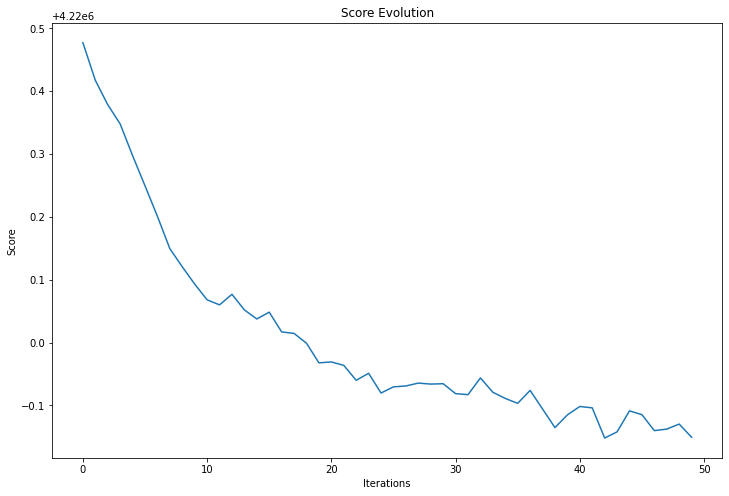

Best players for ['GK', 'CB', 'RB', 'LW']:
M. Sels:
	Age: 27, Overall: 78
M. Škriniar:
	Age: 24, Overall: 86
André Almeida:
	Age: 28, Overall: 81
Jovane Cabral:
	Age: 21, Overall: 75

Max Budget:  100000000
Budget Used:  86000000


In [6]:

def init_population(data, n, positions_target):

    population = []
    for _ in range(n):
        indv = []
        for j in positions_target:
            p = data[data['main_position'] == j].sample(1)
            indv.append(p.iloc[0].short_name)
        population.append(indv)

    return population
    



#One point Crossover
def crossover(indv_1, indv_2):

    if random.random() < prob_crossover:

        pos = random.randint(0,len(indv_1))
        f1 = indv_1[:pos] + indv_2[pos:]
        f2 = indv_2[:pos] + indv_1[pos:]
        return [f1, f2]

    else:
        return [indv_1,indv_2]


def random_mutation(indv, positions, data):
    new_indv = indv.copy()

    for i in range(len(indv)):
        if  random.random() < prob_mutation:
            p = data[data['main_position'] == positions[i]].sample(1)

            new_indv[i] = p.iloc[0]['short_name']

    return new_indv


def evaluate_population(original_data, population, budget):
    alpha = 0.6
    beta = 0
    gamma = 0
    theta = 0.4
    
    max_values = [budget, 35, 7, 10550000]
    
    scores = []
    for indv in population:

        accumulated_value = []
        ages = []
        team_players = []
        for i in indv:
            p = original_data[original_data['short_name'] == i].iloc[0]
            
            accumulated_value.append(1.2 * p.value_eur)
            ages.append(p.age)
            team_players.append(len(original_data[(original_data['club'] == test_team) & (original_data['main_position'] == p.main_position)]))
                
        scores.append(round(alpha * (np.abs(budget - np.sum(accumulated_value))/max_values[0])
                            + beta * (np.median(ages)/max_values[1]) 
                            + gamma * (np.mean(team_players)/max_values[2])
                            + theta * (10550000-np.min(accumulated_value)/max_values[3]), 2))

    return scores

def indv_value(indv, data):

    accumulated_value = 0
    for i in indv:
        p = data[data['short_name'] == i]
        accumulated_value += p.iloc[0].value_eur
        
    return accumulated_value

def argsort_list(seq):
    return [x for x,y in sorted(enumerate(seq), key = lambda x: x[1])]


def elitism(original_data, population, offspring, budget):
    
    scores_pop = evaluate_population(original_data, population, budget)
    scores_offs = evaluate_population(original_data, offspring, budget)
    
    comp_elite = int(len(population) * elitism_size)
    
    population = [population[ind] for ind in argsort_list(scores_pop)]
    offspring = [offspring[ind] for ind in argsort_list(scores_offs)]
    
    new_population = population[:comp_elite] + offspring[:len(population) - comp_elite]

    return new_population


def evolve(data, target_positions, budget):

    num_iters = 50

    scores = np.zeros(num_iters)
    best_indv = None
    best_score = float('+inf')

    population = init_population(data, n_pop, target_positions)

    #print("Initial Population: ", population)
    
    for it in range(num_iters):

        pool = population
        
        #Crossover
        parents = []
        for i in  range(0, n_pop - 1, 2):
            indiv_1= pool[i]
            indiv_2 = pool[i+1]
            parents.extend(crossover(indiv_1, indiv_2)) 
        
        #Mutation
        offspring = []
        for indv in parents:
            offspring.append(random_mutation(indv, target_positions, data))
        
        #Select the best inviduals: Elitism
        population = elitism(fifa_20, population, offspring, budget)
        pop_scores = evaluate_population(data, population, budget)
                
        for i in range(len(pop_scores)):

            if pop_scores[i] < best_score:
                best_indv = pop_scores[i]
                best_players = population[i]
                best_score = pop_scores[i]

        scores[it] = np.mean(pop_scores)

        if it % 5 == 0:
            print("Iteration ", it, ": Average Score:", round(scores[it], 3), "Best so far:", round(best_score, 3), best_players)

        
    plt.figure(figsize=(12, 8))
    plt.plot(scores)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.title('Score Evolution')
    plt.show()
    
    print('Best players for {}:'.format(target_positions))

    for i in best_players:
        p = data[data['short_name'] == i]
        print('{}:\n\tAge: {}, Overall: {}'.format(i, p.iloc[0].age, p.iloc[0].overall))
            
    print('\nMax Budget: ', budget)
    print('Budget Used: ', indv_value(best_players, data))


# CONFIGURATION PARAMETERS

target_pos = ['GK', 'CB', 'RB', 'LW']
b = 100000000
n_pop = 50
prob_mutation = 0.5
prob_crossover = 0.8
elitism_size = 0.6
test_team = 'Juventus'
evolve(fifa_20, target_pos, b)

For this specific configuration, the best set of player found were **[M. Sels, M. Skriniar, Andre Almeida and Jovane Cabral]**, for the positions **['GK', 'CB', 'RB', 'LW']**